<a href="https://colab.research.google.com/github/laurenneal/capstone-visual-neuroscience/blob/main/demo_caiman_cnmf_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Volumetric data processing
This is a simple demo on toy 3d data for source extraction and deconvolution using CaImAn.
For more information check demo_pipeline.ipynb which performs the complete pipeline for
2d two photon imaging data.

In [ ]:
# Clone CaImAn from Github
!git clone https://github.com/flatironinstitute/CaImAn.git

Cloning into 'CaImAn'...
remote: Enumerating objects: 24855, done.
remote: Counting objects: 100% (790/790), done.
remote: Compressing objects: 100% (378/378), done.
remote: Total 24855 (delta 446), reused 709 (delta 398), pack-reused 24065
Receiving objects: 100% (24855/24855), 518.48 MiB | 28.06 MiB/s, done.
Resolving deltas: 100% (16659/16659), done.
Checking out files: 100% (317/317), done.


In [ ]:
# Install relevant packages
%cd /content/CaImAn
!pip install -r requirements.txt
!pip install wget
!pip install ipyparallel
!pip install -e . 
!python caimanmanager.py install --inplace

/content/CaImAn
     |████████████████████████████████| 391 kB 31.8 MB/s 
     |████████████████████████████████| 21.5 MB 1.3 MB/s 
     |████████████████████████████████| 47 kB 4.4 MB/s 
     |████████████████████████████████| 85 kB 4.1 MB/s 
     |████████████████████████████████| 114 kB 71.6 MB/s 
     |████████████████████████████████| 992 kB 50.0 MB/s 
     |████████████████████████████████| 185 kB 75.9 MB/s 
     |████████████████████████████████| 743 kB 43.9 MB/s 
     |████████████████████████████████| 173 kB 73.1 MB/s 
     |████████████████████████████████| 109 kB 63.5 MB/s 
     |████████████████████████████████| 546 kB 49.2 MB/s 
  Created wheel for pims: filename=PIMS-0.5-py3-none-any.whl size=84326 sha256=2168976d2dc801d2efddc20a30219db6434d5bb7a881de18fd43ad40b349d84a
  Stored in directory: /root/.cache/pip/wheels/75/02/a9/86571c38081ba4c1832eb95430b5d588dfa15a738e2a603737
Successfully built pims
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha2

In [ ]:
#%%


try:
    get_ipython().magic(u'load_ext autoreload')
    get_ipython().magic(u'autoreload 2')
    print(1)
except:
    print('NOT IPYTHON')

from ipyparallel import Client
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import psutil
from scipy.ndimage.filters import gaussian_filter
import sys

import caiman as cm
from caiman.utils.visualization import nb_view_patches3d
import caiman.source_extraction.cnmf as cnmf
from caiman.components_evaluation import evaluate_components, estimate_components_quality_auto
from caiman.cluster import setup_cluster
from caiman.paths import caiman_datadir

import bokeh.plotting as bpl
bpl.output_notebook()
logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.DEBUG)

1


In [ ]:
# stop the cluster if one exists
n_processes = psutil.cpu_count()
print('using ' + str(n_processes) + ' processes')
print("Stopping  cluster to avoid unnencessary use of memory....")
sys.stdout.flush()  
cm.stop_server()

using 2 processes
Stopping  cluster to avoid unnencessary use of memory....


      427386 [cluster.py:         stop_server():291] [65] Stopping cluster...
      427388 [cluster.py:         stop_server():296] [65] stop_server: not a slurm cluster
      428024 [cluster.py:         stop_server():334] [65] No cluster to stop...
      428026 [cluster.py:         stop_server():348] [65] stop_cluster(): done


Define a function to create some toy data

In [ ]:
def gen_data(p=1, noise=1., T=256, framerate=30, firerate=2., plot=False):
    if p == 2:
        gamma = np.array([1.5, -.55])
    elif p == 1:
        gamma = np.array([.9])
    else:
        raise
    dims = (30, 40, 50)  # size of image
    sig = (2, 2, 2)  # neurons size
    bkgrd = 10
    N = 20  # number of neurons
    np.random.seed(7)
    centers = np.asarray([[np.random.randint(5, x - 5)
                           for x in dims] for i in range(N)])
    Yr = np.zeros(dims + (T,), dtype=np.float32)
    trueSpikes = np.random.rand(N, T) < firerate / float(framerate)
    trueSpikes[:, 0] = 0
    truth = trueSpikes.astype(np.float32)
    for i in range(2, T):
        if p == 2:
            truth[:, i] += gamma[0] * truth[:, i - 1] + gamma[1] * truth[:, i - 2]
        else:
            truth[:, i] += gamma[0] * truth[:, i - 1]
    for i in range(N):
        Yr[centers[i, 0], centers[i, 1], centers[i, 2]] = truth[i]
    tmp = np.zeros(dims)
    tmp[15, 20, 25] = 1.
    z = np.linalg.norm(gaussian_filter(tmp, sig).ravel())
    Yr = bkgrd + noise * np.random.randn(*(dims + (T,))) + 10 * gaussian_filter(Yr, sig + (0,)) / z
    d1, d2, d3, T = Yr.shape
    Yr = np.reshape(Yr, (d1 * d2 * d3, T), order='F').astype(np.float32)

    if plot:
        Y = np.reshape(Yr, (d1, d2, d3, T), order='F')
        plt.figure(figsize=(15, 3))
        plt.plot(truth.T)
        plt.figure(figsize=(15, 3))
        for c in centers:
            plt.plot(Y[c[0], c[1], c[2]])

        plt.figure(figsize=(15, 4))
        plt.subplot(131)
        plt.scatter(*centers.T[::-1], c='g')
        plt.imshow(Y.max(0).max(-1), cmap='hot')
        plt.title('Max.proj. x & t')
        plt.subplot(132)
        plt.scatter(*centers.T[[2, 0, 1]], c='g')
        plt.imshow(Y.max(1).max(-1), cmap='hot')
        plt.title('Max.proj. y & t')
        plt.subplot(133)
        plt.scatter(*centers.T[[1, 0, 2]], c='g')
        plt.imshow(Y.max(2).max(-1), cmap='hot')
        plt.title('Max.proj. z & t')
        plt.show()

    return Yr, truth, trueSpikes, centers, dims

In [ ]:
Yr, truth, trueSpikes, centers, dims = gen_data(p=2)
Yr.shape

(60000, 256)

## Data creation and memory mapping
- create a toy 3d dataset if it doesn't exist.
- perform memory mapping.

In [ ]:
plt.close('all')
#%% SAVING TIFF FILE ON A SINGLE MEMORY MAPPABLE FILE
demo_filename = os.path.join(caiman_datadir(), 'example_movies', 'demoMovie3D.tif')
try:
    fname_new = cm.save_memmap([demo_filename], base_name='Yr', is_3D=True, order='C')
except:  # %% create 3d tiff file if not yet existent
    from skimage.external.tifffile import imsave
    Yr, truth, trueSpikes, centers, dims = gen_data(p=2)
    data = np.transpose(Yr.reshape(dims + (-1,), order='F'), [3, 0, 1, 2])
    imsave(demo_filename, data)
    fname_new = cm.save_memmap([demo_filename], base_name='Yr', is_3D=True, order='C')

print(fname_new)

      105499 [mmapping.py:         save_memmap():439] [72] /root/caiman_data/example_movies/demoMovie3D.tif
      107436 [mmapping.py:         save_memmap():439] [72] /root/caiman_data/example_movies/demoMovie3D.tif
      107576 [mmapping.py:         save_memmap():514] [72] SAVING WITH numpy.tofile()


/root/caiman_data/example_movies/Yr_d1_30_d2_40_d3_50_order_C_frames_256_.mmap


Load memory mapped file and show a max-projection of the correlation image

      107970 [font_manager.py:    _findfont_cached():1246] [72] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
      107972 [font_manager.py:    _findfont_cached():1258] [72] findfont: score(<Font 'STIXGeneral' (STIXGeneralItalic.ttf) italic normal 400 normal>) = 11.05
      107973 [font_manager.py:    _findfont_cached():1258] [72] findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
      107980 [font_manager.py:    _findfont_cached():1258] [72] findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
      107984 [font_manager.py:    _findfont_cached():1258] [72] findfont: score(<Font 'cmb10' (cmb10.ttf) normal normal 400 normal>) = 10.05
      107986 [font_manager.py:    _findfont_cached():1258] [72] findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
      107990 [font_manager.py:    _findfont_cached():1258] [72

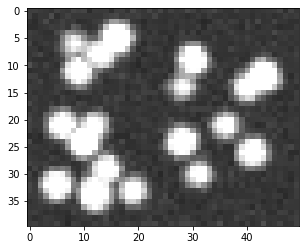

In [ ]:
Yr, dims, T = cm.load_memmap(fname_new)
Y = np.reshape(Yr, dims + (T,), order='F')
Cn = cm.local_correlations(Y)
plt.imshow(Cn.max(0) if len(Cn.shape) == 3 else Cn, cmap='gray',
           vmin=np.percentile(Cn, 1), vmax=np.percentile(Cn, 99))
plt.show()

## Run CNMF
### If data is small enough use a single patch approach

In [ ]:
# set parameters
K = 20  # number of neurons expected per patch
gSig = [2, 2, 2]  # expected half size of neurons
merge_thresh = 0.8  # merging threshold, max correlation allowed
p = 2  # order of the autoregressive system

In [ ]:
%%capture
# START CLUSTER
c, dview, n_processes = setup_cluster(
    backend='local', n_processes=None, single_thread=False)

Initialize CNMF object

In [ ]:
# INIT
cnm = cnmf.CNMF(n_processes, method_init='greedy_roi', k=K, gSig=gSig, merge_thresh=merge_thresh,
                p=p, dview=dview, Ain=None, method_deconvolution='oasis')

### Run CNMF

In [ ]:
%%capture
# FIT
images = np.reshape(Yr.T, [T] + list(dims), order='F')    # reshape data in Python format (T x X x Y x Z)
cnm = cnm.fit(images)

      108832 [params.py:                 set():972] [72] Changing key init_batch in group online from 200 to 256
      108835 [cnmf.py:                 fit():470] [72] (256, 30, 40, 50)
      108847 [params.py:                 set():972] [72] Changing key medw in group spatial from None to (3, 3, 3)
      108850 [cnmf.py:                 fit():487] [72] Using 1 processes
      108852 [cnmf.py:                 fit():498] [72] using 4000 pixels per process
      108856 [cnmf.py:                 fit():499] [72] using 5000 block_size_spat
      108860 [cnmf.py:                 fit():500] [72] using 5000 block_size_temp
      108863 [cnmf.py:                 fit():503] [72] preprocessing ...
      108866 [pre_processing.py:interpolate_missing_data():53] [72] Checking for missing data entries (NaN)
      110398 [cnmf.py:                 fit():506] [72] initializing ...
      110400 [initialization.py:initialize_components():308] [72] Variance Normalization
      110441 [initialization.py:ini

### View components per plane

In [ ]:
cnm.estimates.nb_view_components_3d(image_type = 'mean', dims=dims)

## Run CNMF
### For larger data use a patch approach

In [ ]:
#this breaks but is not needed

"""%%capture
rf = (15, 15, 15)  # half-size of the patches in pixels. rf=25, patches are 50x50
stride = (10, 10, 10)  # amounpl.it of overlap between the patches in pixels
K = 12  # number of neurons expected per patch
gSig = [2, 2, 2]  # expected half size of neurons
merge_thresh = 0.8  # merging threshold, max correlation allowed
p = 2  # order of the autoregressive system
save_results = False
#%% RUN ALGORITHM ON PATCHES
init_method = 'greedy_roi'
alpha_snmf = None  # 10e2  # this controls sparsity

cnm = cnmf.CNMF(n_processes, k=K, gSig=gSig, merge_thresh=0.8, p=p, dview=dview, Ain=None, rf=rf, stride=stride, memory_fact=1,
                method_init=init_method, alpha_snmf=alpha_snmf, only_init_patch=True, gnb=1, method_deconvolution='oasis')
cnm = cnm.fit(images)

print(('Number of components:' + str(cnm.estimates.A.shape[-1])))"""

"%%capture\nrf = (15, 15, 15)  # half-size of the patches in pixels. rf=25, patches are 50x50\nstride = (10, 10, 10)  # amounpl.it of overlap between the patches in pixels\nK = 12  # number of neurons expected per patch\ngSig = [2, 2, 2]  # expected half size of neurons\nmerge_thresh = 0.8  # merging threshold, max correlation allowed\np = 2  # order of the autoregressive system\nsave_results = False\n#%% RUN ALGORITHM ON PATCHES\ninit_method = 'greedy_roi'\nalpha_snmf = None  # 10e2  # this controls sparsity\n\ncnm = cnmf.CNMF(n_processes, k=K, gSig=gSig, merge_thresh=0.8, p=p, dview=dview, Ain=None, rf=rf, stride=stride, memory_fact=1,\n                method_init=init_method, alpha_snmf=alpha_snmf, only_init_patch=True, gnb=1, method_deconvolution='oasis')\ncnm = cnm.fit(images)\n\nprint(('Number of components:' + str(cnm.estimates.A.shape[-1])))"

## Component Evaluation

In [ ]:
#%% COMPONENT EVALUATION
# the components are evaluated in two ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient

fr = 10 # approx final rate  (after eventual downsampling )
decay_time = 1.  # length of typical transient in seconds 
use_cnn = False  # CNN classifier is designed for 2d (real) data
min_SNR = 3      # accept components with that peak-SNR or higher
rval_thr = 0.7   # accept components iwth speace correlation threshold or higher
cnm.params.change_params(params_dict={'fr': fr,
                                      'decay_time': decay_time,
                                      'min_SNR': min_SNR,
                                      'rval_thr': rval_thr,
                                      'use_cnn': use_cnn})

cnm.estimates.evaluate_components(images, cnm.params, dview=dview)

      164099 [params.py:                 set():972] [72] Changing key fr in group data from 30 to 10
      164106 [params.py:                 set():972] [72] Changing key decay_time in group data from 0.4 to 1.0
      164108 [params.py:                 set():972] [72] Changing key min_SNR in group quality from 2.5 to 3
      164110 [params.py:                 set():972] [72] Changing key rval_thr in group quality from 0.9 to 0.7
      164113 [params.py:                 set():972] [72] Changing key use_cnn in group quality from True to False
      164117 [params.py:                 set():972] [72] Changing key min_SNR in group online from 2.5 to 3
      164119 [params.py:                 set():972] [72] Changing key rval_thr in group online from 0.9 to 0.7
      164177 [components_evaluation.py:estimate_components_quality():800] [72] Component evaluation in parallel


In [ ]:
print(('Keeping ' + str(len(cnm.estimates.idx_components)) +
       ' and discarding  ' + str(len(cnm.estimates.idx_components_bad))))

Keeping 20 and discarding  0


## Re-run seeded CNMF
Now we re-run CNMF on the whole FOV seeded with the accepted components.

In [ ]:
%%capture
#%% RE-RUN seeded CNMF on accepted components
cnm.params.set('temporal', {'p': p})
cnm2 = cnm.refit(images)

      164469 [cnmf.py:                 fit():470] [72] (256, 30, 40, 50)
      164471 [cnmf.py:                 fit():487] [72] Using 1 processes
      164473 [cnmf.py:                 fit():498] [72] using 4000 pixels per process
      164476 [cnmf.py:                 fit():499] [72] using 5000 block_size_spat
      164478 [cnmf.py:                 fit():500] [72] using 5000 block_size_temp
      164480 [cnmf.py:                 fit():503] [72] preprocessing ...
      164482 [pre_processing.py:interpolate_missing_data():53] [72] Checking for missing data entries (NaN)
      166052 [cnmf.py:                 fit():543] [72] update spatial ...
      166058 [spatial.py:update_spatial_components():183] [72] Computing support of spatial components
      166633 [spatial.py:update_spatial_components():215] [72] Memory mapping
      166635 [spatial.py:update_spatial_components():221] [72] Updating Spatial Components using lasso lars
      181211 [spatial.py:update_spatial_components():254] [72

## View the results

In [ ]:
# view components per layer
cnm2.estimates.nb_view_components_3d(image_type='corr', dims=dims, Yr=Yr)

In [ ]:
# STOP CLUSTER
cm.stop_server(dview=dview)

      198847 [cluster.py:         stop_server():348] [72] stop_cluster(): done
